In [1]:
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt

/Users/emrekuru/Developer/Finance_RAG/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FinDER

In [2]:
# Load FinDER dataset
finder_data = load_dataset("Linq-AI-Research/FinanceRAG", "FinDER")

In [3]:
finder_data

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 13867
    })
    queries: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 216
    })
})

In [4]:
corpus_data = [{
    "id": doc["_id"],
    "title": doc["title"],
    "text": doc["text"]
} for doc in finder_data['corpus']]  # Only taking the first 3 entries for example

df_corpus = pd.DataFrame(corpus_data)
df_corpus.index = df_corpus['id']
df_corpus.drop(columns=['id'], inplace=True)
df_corpus.index.name = ''
df_corpus.to_csv('FinDER/corpus.csv')

In [5]:
queries_data = [{
    "id": query["_id"],
    "text": query["text"]
} for query in finder_data['queries']]  # Extract all queries

# Convert to pandas DataFrame
df_queries = pd.DataFrame(queries_data)
df_queries.index = df_queries['id']
df_queries.drop(columns=['id'], inplace=True)
df_queries.index.name = ''
df_queries

,text
,
q00001,What are the service and product offerings fro...
q00002,MSFT segment breakdown
q00003,Who are Microsoft`s key customers?
q00004,What is Microsoft`s business model
q00005,MSFT Capex commitment
...,...
q00214,How many distinct insurance underwriting group...
q00215,What is the ticker symbol for Berkshire Hathaw...
q00216,What is the largest operating segment of the B...


In [6]:
qrels = pd.read_csv('resources/finder_qrels.tsv', sep='\t')
qrels_dict = qrels.groupby('query_id')["corpus_id"].apply(list).to_dict()
qrels_dict

{'q00001': ['MSFT20230014', 'MSFT20230015'],
 'q00007': ['MSFT20231529'],
 'q00008': ['MSFT20231529'],
 'q00010': ['ADBE20231571', 'ADBE20231572', 'ADBE20230728', 'ADBE20231573'],
 'q00019': ['CPNG20230732'],
 'q00021': ['CPNG20230658'],
 'q00022': ['CPNG20230553'],
 'q00027': ['LIN20231133'],
 'q00028': ['LIN20231195'],
 'q00030': ['LIN20230064', 'LIN20230065', 'LIN20230066', 'LIN20230067'],
 'q00034': ['LIN20230551'],
 'q00039': ['ORCL20230738', 'ORCL20230739'],
 'q00042': ['ORCL20230129', 'ORCL20230130', 'ORCL20230131'],
 'q00043': ['ORCL20231527', 'ORCL20231529'],
 'q00044': ['ORCL20231505'],
 'q00048': ['NVDA20231260'],
 'q00062': ['PG20230221', 'PG20230805'],
 'q00067': ['PG20230429'],
 'q00070': ['PG20230438'],
 'q00071': ['PG20230440'],
 'q00078': ['DAL20230459'],
 'q00081': ['DAL20230513'],
 'q00092': ['TSLA20230391'],
 'q00095': ['TSLA20231453', 'TSLA20231454'],
 'q00099': ['NFLX20230692', 'NFLX20230006'],
 'q00103': ['NFLX20230387'],
 'q00108': ['NFLX20230380'],
 'q00111': [

In [7]:
def change_na_with_list(x):
    if isinstance(x, list):  
        return x
    elif pd.isna(x):  
        return []
    return x  

In [ ]:
df_queries["Related Documents"] = df_queries.index.map(qrels_dict)
df_queries["Related Documents"] = df_queries["Related Documents"].apply(change_na_with_list)
df_queries.to_csv("FinDER/queries.csv")

## Visualizations

### The lengths of the documents in the corpus

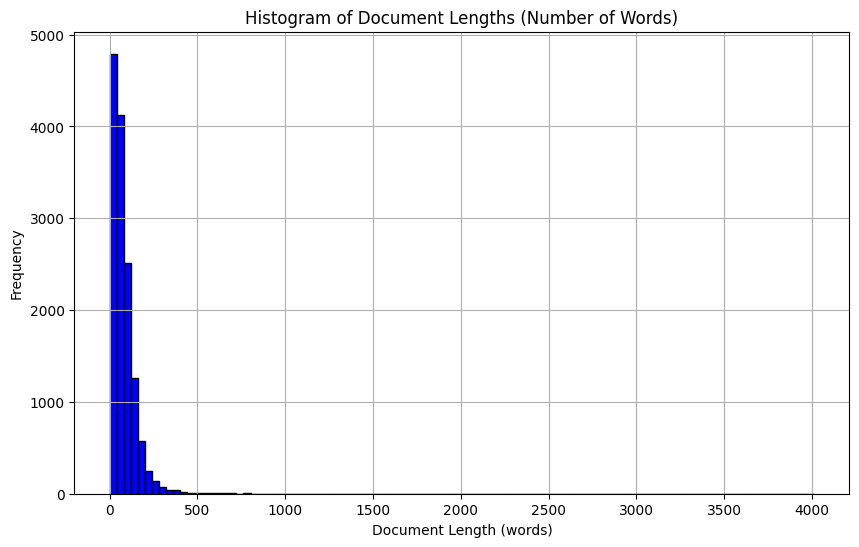

In [9]:
length = df_corpus['text'].apply(lambda x: len(x.split()))

# Plot histogram of document lengths
plt.figure(figsize=(10, 6))
plt.hist(length, bins=100, color='blue', edgecolor='black')
plt.title('Histogram of Document Lengths (Number of Words)')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### How many times the relevant documents been accessed

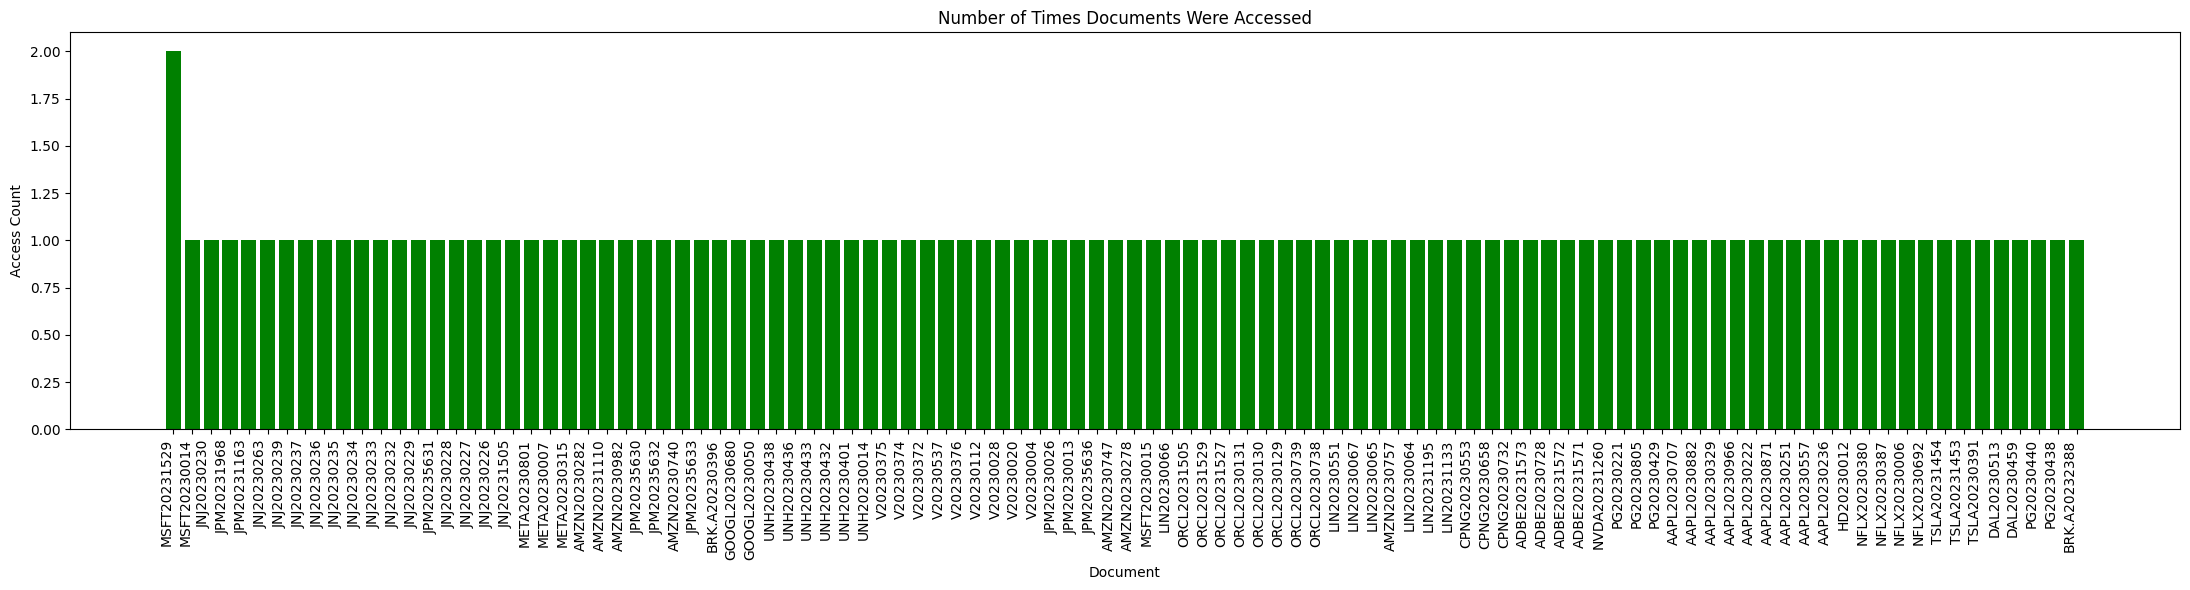

In [10]:
# Create a dictionary to count how many times each document is accessed
doc_access_count = {}

# Loop through qrels_dict and count document access
for query, doc_list in qrels_dict.items():
    for doc in doc_list:
        if doc in doc_access_count:
            doc_access_count[doc] += 1
        else:
            doc_access_count[doc] = 1

# Convert doc_access_count to a pandas DataFrame for easy plotting
df_doc_access = pd.DataFrame(list(doc_access_count.items()), columns=['Document', 'Access Count'])

# Plotting the bar graph of document access count
plt.figure(figsize=(22, 6))
df_doc_access.sort_values(by='Access Count', ascending=False, inplace=True)  # Sort by access count
plt.bar(df_doc_access['Document'], df_doc_access['Access Count'], color='green')
plt.xticks(rotation=90, ha='right')
plt.title('Number of Times Documents Were Accessed')
plt.xlabel('Document')
plt.ylabel('Access Count')
plt.tight_layout()
plt.show()

### How many times a document about a company have been accesed ( group the relevant documents by company basically )

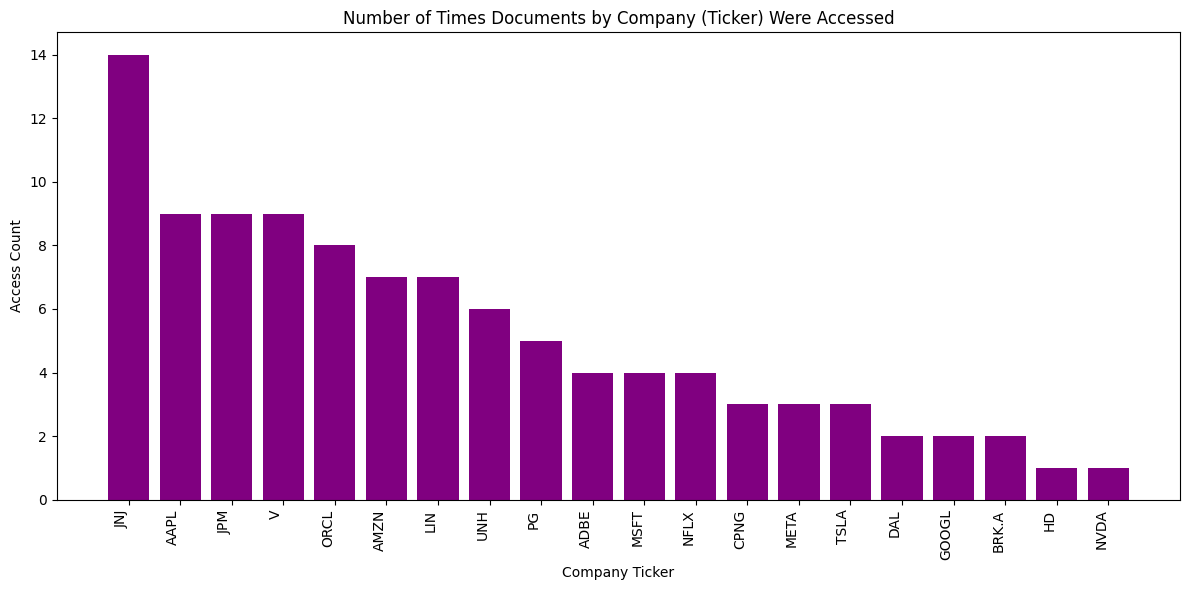

In [11]:
df_doc_access['Ticker'] = df_doc_access['Document'].apply(lambda x: ''.join([c for c in x if not c.isdigit()]).strip())

# Group by ticker and sum up the access counts
df_ticker_access = df_doc_access.groupby('Ticker')['Access Count'].sum().reset_index()

# Plotting the grouped data (by ticker)
plt.figure(figsize=(12, 6))
df_ticker_access.sort_values(by='Access Count', ascending=False, inplace=True)  # Sort by access count
plt.bar(df_ticker_access['Ticker'], df_ticker_access['Access Count'], color='purple')
plt.xticks(rotation=90, ha='right')
plt.title('Number of Times Documents by Company (Ticker) Were Accessed')
plt.xlabel('Company Ticker')
plt.ylabel('Access Count')
plt.tight_layout()
plt.show()

# Other Tasks